In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import os
import sys

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, make_scorer
import xgboost as xgb

%matplotlib inline

In [3]:
class XGBoost_model():
    def __init__(self, **kwargs):
        self.objective = kwargs.get('objective', 'reg:squarederror')
        self.learning_rate = kwargs.get('learning_rate', 0.15)
        self.subsample = kwargs.get('subsample', 1.0)
        self.max_depth = kwargs.get('max_depth', 3)
        self.n_estimators = kwargs.get('n_estimators', 150)
        self.booster = kwargs.get('booster', 'gbtree')
        self.gamma = kwargs.get('gamma', 0)
        self.reg_alpha = kwargs.get('reg_alpha', 0)
        self.reg_lambda = kwargs.get('reg_lambda', 1)
        
        self.model = None

    def opt_hyper_grid(self, x, y, param_space, num_sets: int=10):

        print('Finding best hyper-parameters for the model...')
        estimator = xgb.XGBRegressor(objective=self.objective, max_depth=self.max_depth,
                                     learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                     subsample=self.subsample, booster=self.booster, n_jobs=-1, gamma=self.gamma,
                                     reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda)
        xgb_try = GridSearchCV(estimator=estimator, param_grid=param_space, 
                               cv=KFold(n_splits=num_sets, shuffle=True), 
                               scoring='neg_mean_absolute_error')
        grid_result = xgb_try.fit(x, y)

        means = grid_result.cv_results_['mean_test_score']
        params = grid_result.cv_results_['params']
        
        for mean, param in zip(means, params):
            print("%f  with:   %r" % (mean, param))

        best_params = xgb_try.best_params_
        print('Best params set:', best_params)
        print('Minimum mean absolute error:', -np.max(means))
        print('---------------------------------------------------')
        
        self.learning_rate = best_params.get('learning_rate', self.learning_rate)
        self.max_depth = best_params.get('max_depth', self.max_depth)
        self.subsample = best_params.get('subsample', self.subsample)
        self.n_estimators = best_params.get('n_estimators', self.n_estimators)
        self.booster = best_params.get('booster', self.booster)
        self.gamma = best_params.get('gamma', self.gamma)
        self.reg_alpha = best_params.get('reg_alpha', self.reg_alpha)
        self.reg_lambda = best_params.get('alpha', self.reg_lambda)


    def build_model(self, x, y, params, grid_search: bool = True):
        """
        If use grid search, then each parameter can have multiple values
        
        Example: params = {'learning_rate': [0.1, 0.3],
                           'n_estimators': [100, 200, 300]
                           }
                           
        If do not use grid search, then each parameter should have only one value
        
        Example: params = {'learning_rate': 0.1,
                           'n_estimators': 100
                          }
        
        """
        
        
        if grid_search:
            self.opt_hyper_grid(x, y, params)
        else:

            self.learning_rate = params.get('learning_rate', self.learning_rate)
            self.max_depth = params.get('max_depth', self.max_depth)
            self.subsample = params.get('subsample', self.subsample)
            self.n_estimators = params.get('n_estimators', self.n_estimators)
            self.booster = params.get('booster', self.booster)
            self.gamma = params.get('gamma', self.gamma)
            self.reg_alpha = params.get('reg_alpha', self.reg_alpha)
            self.reg_lambda = params.get('alpha', self.reg_lambda)

        xgb_reg = xgb.XGBRegressor(objective=self.objective, max_depth=self.max_depth,
                                   learning_rate=self.learning_rate, n_estimators=self.n_estimators,
                                   subsample=self.subsample, booster=self.booster, gamma=self.gamma,
                                   n_jobs=-1, reg_alpha=self.reg_alpha, reg_lambda=self.reg_lambda)
        # 10 fold cross-validation
        sk = KFold(n_splits=10, shuffle=True)
        scores_train = list()
        scores_val = list()
        for train_ind, val_ind in sk.split(x, y):
            train_x = x.iloc[train_ind].values
            train_y = y.iloc[train_ind]
            val_x = x.iloc[val_ind].values
            val_y = y.iloc[val_ind]

            xgb_reg.fit(train_x, train_y)
            pred_train_xgb = xgb_reg.predict(train_x)
            pred_val_xgb = xgb_reg.predict(val_x)

            score_train = mean_absolute_error(train_y, pred_train_xgb)
            scores_train.append(score_train)
            score_val = mean_absolute_error(val_y, pred_val_xgb)
            scores_val.append(score_val)

        print('Train mean absolute error:', np.mean(scores_train))
        print('Val mean absolute error:', np.mean(scores_val))
        print("Train score: ", scores_train)
        print("Validation score: ", scores_val)
        
        self.model = xgb_reg

        return xgb_reg, scores_train, scores_val

    
    def save_model(self, model_path):
        print('Saving model...')
        joblib.dump(self.model, model_path)
        print('Model saved.')


    def predict_with_model(self, x_test):
        y_test_pred = self.model.predict(x_test)
        return y_test_pred

In [4]:
# Load the data
BTC_BUSD = pd.read_csv("../Data/BTC2.csv")

In [5]:
# Check if there is any NaN values
for col_name, _ in BTC_BUSD.iteritems():
    if len(BTC_BUSD[BTC_BUSD[col_name].isna()])>0:
        print("%s: %s rows" % (col_name, len(BTC_BUSD[BTC_BUSD[col_name].isna()])))

Text(0, 0.5, 'BTC-BUSD close price')

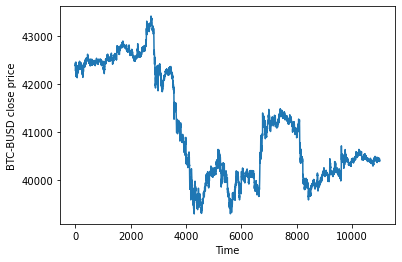

In [6]:
# Show the plot
plt.plot(BTC_BUSD['close'])
plt.xlabel('Time')
plt.ylabel('BTC-BUSD close price')

## Use Twitter data for price prediction

In [7]:
# Option 1: Use all features
BTC_BUSD_copy = BTC_BUSD.copy()
BTC_BUSD_copy.reset_index(drop=True, inplace=True)
BTC_BUSD_copy.head()

,open_time,avg,wgtavg,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2022-04-08 22:33:00,0.106600,-0.076148,42409.00,42409.01,42367.01,42384.64,3.75072,158990.77,254,1.41116,59816.070
1,2022-04-08 22:34:00,0.228277,0.047320,42384.63,42387.50,42344.08,42373.66,5.21452,220892.70,229,1.48407,62871.580
2,2022-04-08 22:35:00,0.142080,0.078871,42369.76,42424.41,42369.75,42415.69,5.10597,216482.45,213,3.03908,128832.950
3,2022-04-08 22:36:00,0.207449,0.232077,42415.68,42453.85,42415.42,42439.52,5.04461,214064.31,252,3.75288,159234.840
4,2022-04-08 22:37:00,0.163528,0.358569,42439.51,42451.54,42412.62,42415.94,2.93812,124666.83,162,0.69743,29594.648


In [9]:
# Determine if grid search is necessary
grid_search = False

# Determine if we want to save the new trained models
save_model = True

    
# Set predict time (e.g. m=5 represents "5 minutes later")
for m in range(1, 6):
    
    print("Start build model to predcit price %d minutes later........." % (m))
    
    # Set target predict price (m minutes later)
    target_price = BTC_BUSD_copy['close'].shift(-m, fill_value=BTC_BUSD_copy['close'].iloc[-1]).rename("price_m_min_later")
    target_price_diff = (target_price - BTC_BUSD_copy['close']).rename("price_diff_m_min_later")
    # Get dataset
    dataset = pd.concat([BTC_BUSD_copy, target_price, target_price_diff], axis=1)
    


    # Determine if we want to predict price difference
    diff = True

    if diff:
        X_train = dataset.iloc[:, 1:-2]

        # Use price difference as the target
        Y_train = dataset.iloc[:, -1]

    else:
        X_train = dataset.iloc[:, 1:-2]

        # Use future price as the target
        Y_train = dataset.iloc[:, -2]





    # With hyperparameter grid search
    if grid_search:
        task = XGBoost_model()

        params = {'learning_rate': [0.03, 0.1, 0.3],
                   'n_estimators': [100, 200, 300]

        }

        xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Without hyperparameter grid search
    else:
        task = XGBoost_model()

        params = {'learning_rate': 0.1,
                   'n_estimators': 200

        }

        xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=False)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Save model
    if save_model:

        save_path = "Models/xgboost_" + str(m) + "_minutes_later.pkl"
        task.save_model(save_path)

    print("=" * 50)



Start build model to predcit price 1 minutes later.........
Train mean absolute error: 16.488925543346596
Val mean absolute error: 17.91884804876821
Train score:  [16.511811066832422, 16.521335346695704, 16.4870586631736, 16.38534742431105, 16.451267307703297, 16.408362569409334, 16.551372983871172, 16.51328633672913, 16.484102146203288, 16.575311588536945]
Validation score:  [17.707526249005856, 17.572033693447217, 18.342134795876806, 18.233659737440803, 17.95957061833571, 18.813092736681202, 17.25628663162724, 18.01296271587226, 18.042389269523635, 17.24882403987137]
Saving model...
Model saved.
Start build model to predcit price 2 minutes later.........
Train mean absolute error: 23.564218685085358
Val mean absolute error: 25.495306875797354
Train score:  [23.493082996058774, 23.592753888574016, 23.589837372436637, 23.71973810239941, 23.672766667998875, 23.497884644151924, 23.472523665843617, 23.572527984020635, 23.448238656042317, 23.58283287332737]
Validation score:  [26.715290031

In [10]:
# Load the save models
xgboost_models = []
m_min, m_max = 1, 5
for m in range(m_min, m_max+1):
    load_path = "Models/xgboost_" + str(m) + "_minutes_later.pkl"
    if os.path.exists(load_path):
        xgboost_models.append(joblib.load(load_path))
    else:
        print("Warning: model %d does not found." % (m))

In [11]:
# Evaluate validation set performance of each fold in cross-validation
N = len(BTC_BUSD_copy)
s_points = np.linspace(0, N, 11, dtype=int)

mae_error_list, mape_error_list = [], []
for i in range(len(s_points)-1):
    st_point = s_points[i]
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    pred_length = s_points[i+1] - s_points[i]
    price_pred = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (xgboost_models[j].predict(BTC_BUSD_copy.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred.append(cur_sum / cur_portion if cur_portion !=0 else 0)

    price_true = BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['close'].values
    mae_error_list.append(mean_absolute_error(price_true, price_pred))
    mape_error_list.append(mean_absolute_percentage_error(price_true, price_pred))
print("MAE: ", mae_error_list)
print("MAPE: ", mape_error_list)

MAE:  [44.06065700757566, 24.24460411931817, 45.394017376894084, 63.940013399621236, 51.420891619318056, 47.61210932765132, 46.54762097537898, 43.045757244318374, 35.32485156250011, 19.683331062670486]
MAPE:  [0.001039308121680644, 0.0005686323371794482, 0.0010668452380309728, 0.0015725050442787953, 0.0012847896564067893, 0.0011939369943219987, 0.0011352998715302041, 0.001065543134299654, 0.000877569000155364, 0.0004866182974105343]


In [12]:
print("Mean MAE: ", np.average(mae_error_list))
print("Man MAPE: ", np.average(mape_error_list))

Mean MAE:  42.127385369524646
Man MAPE:  0.0010291047695294407


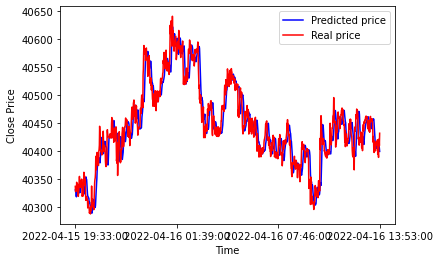

In [13]:
plt.plot(BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['open_time'], price_pred,'b', label='Predicted price')
plt.plot(BTC_BUSD_copy.iloc[st_point:st_point+pred_length]['open_time'], price_true, 'r', label="Real price")
plt.legend()
plt.xlabel("Time")
plt.xticks([BTC_BUSD_copy.iloc[i]['open_time'] for i in np.linspace(st_point, st_point+pred_length-1, 4, dtype=int)])
plt.ylabel("Close Price")
plt.show()

# Do not use Twitter Data

In [14]:
# Option 2: Do not use twitter information
BTC_BUSD_copy2 = BTC_BUSD.copy().drop(labels=['avg','wgtavg'],axis=1)
BTC_BUSD_copy2.reset_index(drop=True, inplace=True)
BTC_BUSD_copy2.head()

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2022-04-08 22:33:00,42409.00,42409.01,42367.01,42384.64,3.75072,158990.77,254,1.41116,59816.070
1,2022-04-08 22:34:00,42384.63,42387.50,42344.08,42373.66,5.21452,220892.70,229,1.48407,62871.580
2,2022-04-08 22:35:00,42369.76,42424.41,42369.75,42415.69,5.10597,216482.45,213,3.03908,128832.950
3,2022-04-08 22:36:00,42415.68,42453.85,42415.42,42439.52,5.04461,214064.31,252,3.75288,159234.840
4,2022-04-08 22:37:00,42439.51,42451.54,42412.62,42415.94,2.93812,124666.83,162,0.69743,29594.648


In [15]:
# Determine if grid search is necessary
grid_search = False

# Determine if we want to save the new trained models
save_model = True


# Set predict time (e.g. m=5 represents "5 minutes later")
for m in range(1, 6):
    
    print("Start build model to predcit price %d minutes later........." % (m))
    
    # Set target predict price (m minutes later)
    target_price = BTC_BUSD_copy2['close'].shift(-m, fill_value=BTC_BUSD_copy2['close'].iloc[-1]).rename("price_m_min_later")
    target_price_diff = (target_price - BTC_BUSD_copy2['close']).rename("price_diff_m_min_later")
    # Get dataset
    dataset = pd.concat([BTC_BUSD_copy2, target_price, target_price_diff], axis=1)
    


    # Determine if we want to predict price difference
    diff = True

    if diff:
        X_train = dataset.iloc[:, 1:-2]

        # Use price difference as the target
        Y_train = dataset.iloc[:, -1]

    else:
        X_train = dataset.iloc[:, 1:-2]

        # Use future price as the target
        Y_train = dataset.iloc[:, -2]





    # With hyperparameter grid search
    if grid_search:
        task = XGBoost_model()

        params = {'learning_rate': [0.05, 0.1, 0.3],
                  'max_depth': [2,3],
                  'n_estimators': [100, 150, 200]

        }

        xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=True)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Without hyperparameter grid search
    else:
        task = XGBoost_model()

        params = {'learning_rate': 0.1, 
                  'max_depth': 3,
                  'n_estimators': 200

        }

        xgb_reg, scores_train, scores_val = task.build_model(X_train, Y_train, params, grid_search=False)
#         Y_test_pred = task.predict_with_model(X_test)
#         print("Test mean absolute error: %f" % (mean_absolute_error(Y_test, Y_test_pred)))

    # Save model
    if save_model:

        save_path = "Models/xgboost_" + str(m) + "_minutes_later_no_twitter_try.pkl"
        task.save_model(save_path)

    print("=" * 50)


Start build model to predcit price 1 minutes later.........
Train mean absolute error: 16.569989994320988
Val mean absolute error: 17.8725696903593
Train score:  [16.58315999398092, 16.599063773036765, 16.613846345138498, 16.605424321376958, 16.566347738578465, 16.594581988083725, 16.485336065545578, 16.59405123894856, 16.591515286305665, 16.466573192214785]
Validation score:  [17.389080875731562, 17.622297265228354, 17.63733703923962, 17.8634171304179, 18.10347461348749, 17.533392611068173, 18.603982852574216, 17.794586749818404, 17.921568213094147, 18.256559552933123]
Saving model...
Model saved.
Start build model to predcit price 2 minutes later.........
Train mean absolute error: 23.64567342426891
Val mean absolute error: 25.63954873534349
Train score:  [23.603042086949877, 23.65307577891571, 23.74200526758255, 23.685987385932243, 23.555224904686153, 23.643557801746738, 23.697269016928423, 23.678652344619135, 23.58961784923758, 23.608301806090665]
Validation score:  [26.00897925418

In [18]:
xgboost_models_nt = []
m_min, m_max = 1, 5
for m in range(m_min, m_max+1):
    load_path = "Models/xgboost_" + str(m) + "_minutes_later_no_twitter_try.pkl"
    if os.path.exists(load_path):
        xgboost_models_nt.append(joblib.load(load_path))
    else:
        print("Warning: model %d does not found." % (m))

In [19]:
N = len(BTC_BUSD_copy2)
s_points = np.linspace(0, N, 11, dtype=int)

mae_error_list, mape_error_list = [], []
for i in range(len(s_points)-1):
    st_point = s_points[i]
    weights = [(m-i)/np.sum(np.arange(m+1)) for i in range(m)]
    pred_length = s_points[i+1] - s_points[i]
    price_pred2 = []
    for i in range(pred_length):
        cur_sum = 0
        cur_portion = 0
        for j in range(m):
            if st_point-((j+m)-i) < st_point + pred_length:
                cur_sum += weights[j] * (xgboost_models_nt[j].predict(BTC_BUSD_copy2.iloc[st_point-((j+m)-i), 1:].values.reshape(1,-1)) + BTC_BUSD_copy2.iloc[st_point-((j+m)-i)]['close'])[0]
                cur_portion += weights[j]
        price_pred2.append(cur_sum / cur_portion if cur_portion !=0 else 0)

    price_true = BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['close'].values
    mae_error_list.append(mean_absolute_error(price_true, price_pred2))
    mape_error_list.append(mean_absolute_percentage_error(price_true, price_pred2))
print("MAE: ", mae_error_list)
print("MAPE: ", mape_error_list)

MAE:  [44.096519412879005, 24.323576562499987, 45.454214062499794, 63.94586268939406, 51.462678361742555, 48.30658106060607, 46.562807481060666, 43.09301467803027, 35.24422741477274, 19.724516585301124]
MAPE:  [0.0010401465328816308, 0.0005704859320071708, 0.0010683601957784269, 0.0015724678839883518, 0.0012858306084059827, 0.0012113094904345038, 0.0011356894553692823, 0.0010667613456185037, 0.0008755763315857288, 0.0004876356826920778]


In [20]:
print("Mean MAE: ", np.average(mae_error_list))
print("Man MAPE: ", np.average(mape_error_list))

Mean MAE:  42.22139983087863
Man MAPE:  0.001031426345876166


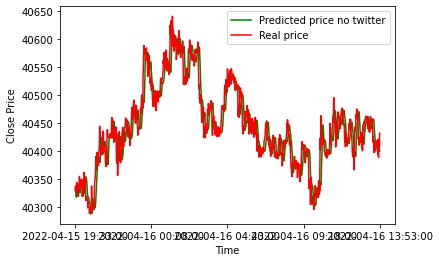

In [21]:
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], price_pred2,'g', label='Predicted price no twitter')
plt.plot(BTC_BUSD_copy2.iloc[st_point:st_point+pred_length]['open_time'], price_true, 'r', label="Real price")
plt.legend()
plt.xlabel("Time")
plt.xticks([BTC_BUSD_copy.iloc[i]['open_time'] for i in np.linspace(st_point, st_point+pred_length-1, 5, dtype=int)])
plt.ylabel("Close Price")
plt.show()